In [2]:
%load_ext autoreload
%autoreload 2

In [30]:
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/gsk6me/huggingface_cache'
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [3]:
import argparse
import logging
import math
import os
import random
import shutil
from pathlib import Path

import accelerate
import datasets
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import torch.utils.data
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.state import AcceleratorState
from accelerate.utils import ProjectConfiguration, set_seed
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from transformers.utils import ContextManagers

import diffusers
from diffusers import AutoencoderKLTemporalDecoder, DDPMScheduler, StableVideoDiffusionPipeline, UNetSpatioTemporalConditionModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel, compute_snr
from diffusers.image_processor import VaeImageProcessor
from diffusers.utils import check_min_version, deprecate, is_wandb_available, make_image_grid
from diffusers.utils.hub_utils import load_or_create_model_card, populate_model_card
from diffusers.utils.import_utils import is_xformers_available
from diffusers.utils.torch_utils import is_compiled_module

from rt1_dataset_wrapper import RT1Dataset


if is_wandb_available():
    import wandb

/home/gsk6me/miniconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/gsk6me/miniconda3/envs/py310/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-02-29 13:23:33.502658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load Pipelines

We have a base pipeline, which is only image-conditioned, and we have a LoRA pipeline, which has had low-rank weight updates made.

In [10]:
# Load the base pipeline
pipeline_base = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt",
    torch_dtype=torch.float16,
)
pipeline_base = pipeline_base.to(device='cuda')

pipeline_lora = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt",
    torch_dtype=torch.float16,
)
pipeline_lora = pipeline_lora.to(device='cuda')

Keyword arguments {'device': 'cuda'} are not expected by StableVideoDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Keyword arguments {'device': 'cuda'} are not expected by StableVideoDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## Inject LoRA

Because the regular pipeline doesn't have an easy way to load LoRA adapters directly, I just manually add them to the U-Net weights. We need to use HuggingFace's SafeTensors library for this.

In [14]:
from peft import LoraConfig

rank = 16
unet_lora_config = LoraConfig(
    r=rank,
    lora_alpha=rank,
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)
pipeline_lora.unet.add_adapter(unet_lora_config)

from safetensors import safe_open

tensors = {}
with safe_open("./sd-model-finetuned/unet/diffusion_pytorch_model.safetensors", framework="pt", device=0) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)
        # print("Loading tensor", k)

pipeline_lora.unet.load_state_dict(tensors)

## Unify with Text Encoder

Here, we create a unified trajectory synthesis pipeline, which is conditioned on text inputs.

In [42]:
from text_and_image_conditioned_video_diffusion_model import VisualTrajectorySynthesizer

# Load the text encoder. This only works for the LoRA model.
text_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
text_encoder = CLIPTextModel.from_pretrained(text_encoder_path).to(device='cuda', dtype=torch.float16)
tokenizer = CLIPTokenizer.from_pretrained(text_encoder_path)

pipeline_lora_unified = VisualTrajectorySynthesizer.from_stable_video_diffusion_pipeline(pipeline_lora, text_encoder)

## Load Data

We only trained on the first $20$ samples from the RT-1 dataset, and of those, we only trained on the first $25$ frames of each video. Let's see how they turned out. We will use the custom class I wrote, `RT1Dataset`, for this. We also need to do a bit of image processing before we can directly send inputs into the model.

In [43]:
from rt1_dataset_wrapper import RT1Dataset

# Originally from `args`
image_height = 256
image_width = 320
vae_image_processor = pipeline_lora.image_processor

# We don't technically even have to do this because the `vae_image_processor` is already called in the StableVideoDiffusionPipeline
def collate_fn(batch):
    # input: (text, image_sequence)[]
    # return: (text batch, text attention masks, text sequence lengths, images)
    text_batch = [text for (text, imgseq) in batch]
    tokenization = tokenizer(text_batch, padding='longest', return_tensors='pt')
    text_tokens = tokenization['input_ids']
    text_attention_masks = tokenization['attention_mask']

    imgseqs = [vae_image_processor.preprocess(imgseq, height=image_height, width=image_width) for (_, imgseq) in batch]

    return (text_tokens, text_attention_masks, torch.stack(imgseqs))

dataset = RT1Dataset('/scratch/gsk6me/WORLDMODELS/datasets/rt-1-data-release')

In [44]:
text, image_sequence = dataset[0]
input_ids = tokenizer(text, return_tensors='pt').input_ids

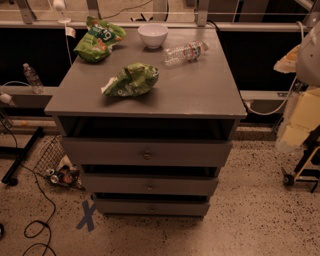

In [45]:
# Use the first image as conditioning
# Note that because training only occurred over the first 25 frames of each video,
# the model has not seen robots performing task completion yet.
import PIL.Image

conditioning_image_tensor = image_sequence[0]
conditioning_image_np = np.array((image_sequence[0] * 255).permute(1, 2, 0)).astype(np.uint8)
conditioning_image_pil = PIL.Image.fromarray(conditioning_image_np)

conditioning_image_pil

In [47]:
from diffusers.utils import export_to_video

In [48]:
frames = pipeline_lora_unified.custom_call(conditioning_image_pil, input_ids, width=image_width, height=image_height)
export_to_video(frames[0], "generated_lora.mp4", fps=7)

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.2546, -0.3799,  0.0656,  ...,  0.1837,  0.0816, -0.3835],
         [ 0.3843,  0.6553, -0.3020,  ...,  1.1660,  0.7383, -0.9102],
         [ 0.2107,  0.1082, -2.0918,  ..., -0.1875,  1.8955, -1.3477],
         [ 0.1605,  0.4241,  0.0748,  ..., -0.1385, -0.3008,  0.8154],
         [ 0.3262,  0.2437, -0.3157,  ...,  0.2820, -1.0430, -0.0968]]],
       device='cuda:0', dtype=torch.float16), pooler_output=tensor([[ 0.3262,  0.2437, -0.3157,  ...,  0.2820, -1.0430, -0.0968]],
       device='cuda:0', dtype=torch.float16), hidden_states=None, attentions=None)
torch.Size([1, 1024])


  0%|          | 0/25 [00:00<?, ?it/s]

'generated_lora.mp4'

In [54]:
frames = pipeline_base(conditioning_image_pil, width=image_width, height=image_height)
export_to_video(frames[0][0], "generated_non_lora.mp4", fps=7)

  0%|          | 0/25 [00:00<?, ?it/s]

'generated_non_lora.mp4'

In [55]:
# !ffmpeg -i generated_lora.mp4 generated_lora_converted.mp4
!ffmpeg -i generated_non_lora.mp4 generated_non_lora_converted.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu